<a href="https://colab.research.google.com/github/Anushka-Sharma-sahariya/Pinnochio-s-Nose/blob/main/ai_image_detection_pc_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from google.colab import files
import zipfile
import io
import os
uploaded = files.upload()

Saving archive (6).zip to archive (6).zip


In [3]:
file_name ="archive (6).zip"

try:
    with zipfile.ZipFile(file_name, 'r') as zip:
        zip.extractall()
        print('Done')
except zipfile.BadZipFile:
    print(f"Error: {file_name} is not a valid zip file.")

Done


Imports:

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from matplotlib import pyplot as plt
import numpy as np

# GPU memory growth configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

with zipfile.ZipFile('archive (6).zip', 'r') as zip_ref:
    zip_ref.extractall('data/')  # Extract to a directory named 'data/'

# Load image dataset
data = tf.keras.utils.image_dataset_from_directory('data/train', image_size=(32, 32))

Found 100000 files belonging to 2 classes.


Pre-Processing:

0.0
255.0
3125


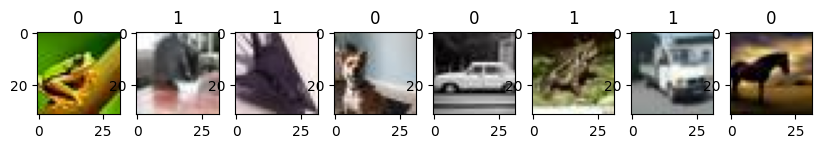

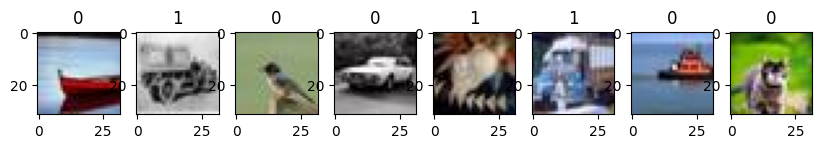

In [6]:
# Visualize a batch of images
data_it = data.as_numpy_iterator()
batch = data_it.next()

fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

print(batch[0].min())
print(batch[0].max())

# Scale pixel values to the range [0, 1]
data = data.map(lambda x, y : (x/255, y))

# Visualize a scaled batch of images
scaled_it = data.as_numpy_iterator()
batch = scaled_it.next()

fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(float))
    ax[idx].title.set_text(batch[1][idx])

# Split the dataset
train_size = int(len(data) * 0.7)
cv_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1) + 1

train = data.take(train_size)
cv = data.skip(train_size).take(cv_size)
test = data.skip(train_size + cv_size).take(test_size)

print(len(train) + len(cv) + len(test))

Building the CNN Model:

In [7]:
# Define the CNN model with enhancements
model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 30, 30, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 13, 13, 128)       512       
 chNormalization)                                                
                                                        

Data Augumentation and Training:

In [8]:
# Learning rate scheduler
initial_learning_rate = 0.001
def lr_scheduler(epoch, lr):
    return lr * 0.95  # Adjust the decay factor as needed
lr_schedule = LearningRateScheduler(lr_scheduler)
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Data Augmentation in the pipeline
def augment_data(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    x = tf.image.random_brightness(x, max_delta=0.1)
    x = tf.image.random_contrast(x, lower=0.9, upper=1.1)
    return x, y

train_augmented = data.map(augment_data)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(train_augmented, validation_data=cv, epochs=10, callbacks=[lr_schedule, early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10
3125/3125 [==============================] - 521s 166ms/step - loss: 0.3025 - accuracy: 0.8747 - val_loss: 0.4161 - val_accuracy: 0.8185 - lr: 9.5000e-04
Epoch 2/10
3125/3125 [==============================] - 509s 163ms/step - loss: 0.2260 - accuracy: 0.9098 - val_loss: 0.3164 - val_accuracy: 0.8748 - lr: 9.0250e-04
Epoch 3/10
3125/3125 [==============================] - 514s 165ms/step - loss: 0.2011 - accuracy: 0.9208 - val_loss: 0.4114 - val_accuracy: 0.8510 - lr: 8.5737e-04
Epoch 4/10
3125/3125 [==============================] - 509s 163ms/step - loss: 0.1849 - accuracy: 0.9275 - val_loss: 0.1668 - val_accuracy: 0.9323 - lr: 8.1451e-04
Epoch 5/10
3125/3125 [==============================] - 492s 157ms/step - loss: 0.1687 - accuracy: 0.9344 - val_loss: 0.4477 - val_accuracy: 0.8289 - lr: 7.7378e-04
Epoch 6/10
3125/3125 [==============================] - 502s 161ms/step - loss: 0.1589 - accuracy: 0.9385 - val_loss: 0.1601 - val_accuracy: 0.9360 - lr: 7.3509e-04
Epoch 7/10

In [15]:
model.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
from google.colab import files


In [17]:
files.download('my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Plotting the Acccuracy:

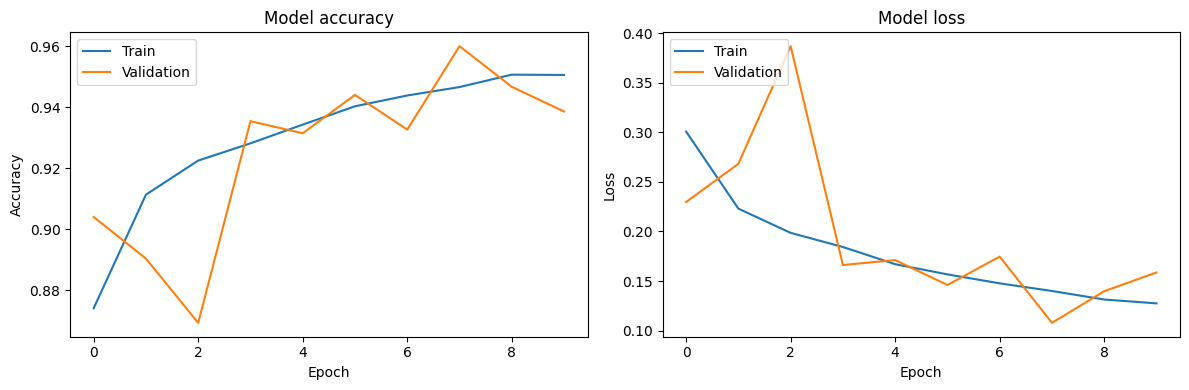

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


Metrics:

In [9]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Recall: {rec.result().numpy()}, Precision: {pre.result().numpy()}, Accuracy: {acc.result().numpy()}')

1/1 [==============================] - 0s 46ms/step
Recall: 0.9902117252349854, Precision: 0.855392575263977, Accuracy: 0.9114416837692261


Saving the Model:

In [10]:
from tensorflow.keras.models import load_model
from keras.models import load_model

model.save('model/ai_imageclassifier', save_format='tf')

loaded_model = tf.keras.models.load_model('model/ai_imageclassifier')

Prediction using the model:

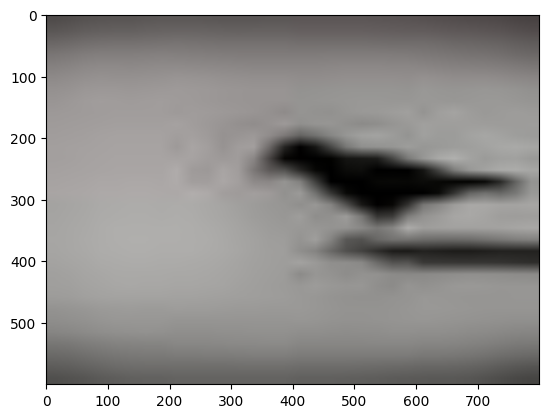

In [11]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/test/FAKE/10 (3).jpg'

try:
    img = cv2.imread(image_path)

    # Check if the image is loaded successfully
    if img is None:
        raise FileNotFoundError(f"Could not read the image from {image_path}")

    # Resize the image to a larger size
    img = cv2.resize(img, (800, 600))

    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the resized image
    plt.imshow(img)
    plt.show()

except Exception as e:
    print(f"Error: {e}")



In [12]:
resize = tf.image.resize(img, (32, 32))

y_pred = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 160ms/step


In [13]:
y_pred

array([[0.00331026]], dtype=float32)

In [14]:
if y_pred > 0.5:
    print(f'Predicted class: REAL')
else:
    print(f'Predicted class: FAKE')

Predicted class: FAKE
